In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
folder_path = '/content/drive/MyDrive/Number_Plate/'
files = os.listdir(folder_path)
print(files)


['.DS_Store', 'dataset', 'anchors.py', 'ciou_loss.py', 'focal_loss.py', 'loss.py', 'wandb_config.py', 'dataset.py', '__pycache__', 'wandb', '.env', 'evaluation.py', 'utils.py', 'model.py', 'run.py', 'best_model_trial_0.pth', 'best_model_trial_1.pth', 'best_model_trial_2.pth', 'best_model_trial_3.pth', 'best_model_trial_4.pth', 'best_model_trial_5.pth', 'best_model_trial_6.pth', 'best_model_trial_7.pth', 'best_model_trial_8.pth', 'best_model_trial_9.pth', 'best_model_trial_11.pth', 'best_model_trial_12.pth', 'best_model_trial_13.pth', 'best_model_trial_14.pth', 'best_model_trial_15.pth']


In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"


In [ ]:
import torch
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import os
from PIL import Image
import torchvision.transforms.functional as TF


## ------------------------------------------------------------------------
## The previous dataset loader not supported yolo file format annoation
## This is new dataset loader for ximl annotation loader for FRCNN training
## -------------------------------------------------------------------------

class VOCDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transforms=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        annot_path = os.path.join(self.annot_dir, os.path.splitext(self.images[idx])[0] + '.xml')

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


from torch.utils.data import DataLoader

def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = [TF.to_tensor(img) for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

dataset = VOCDataset('/content/drive/MyDrive/INM_705_Practice_final/Datasets/images', '/content/drive/MyDrive/INM_705_Practice_final/Datasets/annotations')
data_loader = DataLoader(dataset, batch_size=16, shuffle=True,num_workers=2, collate_fn=collate_fn)


In [ ]:
!pip install torchmetrics


In [ ]:
def print_model_size(model):
    total_pars = 0
    for _n, _par in model.state_dict().items():     ## this code will go to utils.py
        total_pars += _par.numel()
    print(f"Total number of parameters: {total_pars}")
    return

In [4]:
import os                               ## testing pupose
import torch                           ## i have to format this code to model.py and run.py
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import wandb
from torchvision.transforms import ToTensor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchmetrics.detection.mean_ap import MeanAveragePrecision
#from dataset import VOCDataset
#from utils import print_model_size

def print_model_size(model):
    total_pars = 0
    for _n, _par in model.state_dict().items():
        total_pars += _par.numel()
    print(f"Total number of parameters: {total_pars}")
    return

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2
EPOCHS = 50
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
TRAIN_IMG_DIR = "/content/drive/MyDrive/INM_705_Practice_final/Datasets/images"
TRAIN_ANNOT_DIR = "/content/drive/MyDrive/INM_705_Practice_final/Datasets/annotations"
CHECKPOINT_PATH = "frcnn_best.pth"

def build_resnet50_frcnn(num_classes):
    # pretrained model referneced form torch vision of pytorch
    backbone = resnet_fpn_backbone(
        backbone_name="resnet50",
        weights=torchvision.models.ResNet50_Weights.DEFAULT,
        trainable_layers=3
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes
    )
    return model

def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = [ToTensor()(img) for img in images]
    return images, targets

def evaluate(model, dataloader, epoch):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(DEVICE) for img in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            outputs = model(images)
            metric.update(outputs, targets)
    results = metric.compute()
    wandb.log({"val_mAP": results["map"], "val_mAP50": results["map_50"], "val_recall": results["mar_100"], "epoch": epoch})
    print(f"Epoch {epoch} - mAP: {results['map']:.4f}, Recall: {results['mar_100']:.4f}")

def main():
    wandb.init(
        project="frcnn_project",
        name="frcnn_training",
        config={
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "lr": LEARNING_RATE,
        }
    )

    train_dataset = VOCDataset(TRAIN_IMG_DIR, TRAIN_ANNOT_DIR)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_dataset = VOCDataset(TRAIN_IMG_DIR, TRAIN_ANNOT_DIR)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = build_resnet50_frcnn(num_classes=NUM_CLASSES)
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_map = 0
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, targets in train_loader:
            images = list(img.to(DEVICE) for img in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        avg_loss = total_loss / len(train_loader)
        wandb.log({"train_loss": avg_loss, "epoch": epoch})
        print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")

        evaluate(model, val_loader, epoch)

        current_map = wandb.run.summary.get("val_mAP", 0.0)
        if current_map > best_map:
            best_map = current_map
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            artifact = wandb.Artifact("frcnn_best_model", type="model")
            artifact.add_file(CHECKPOINT_PATH)
            wandb.log_artifact(artifact)

if __name__ == '__main__':
    main()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abhi1199 (abhi1199-city-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0 | Train Loss: 0.1773
Epoch 0 - mAP: 0.1955, Recall: 0.4340
Epoch 1 | Train Loss: 0.1118
Epoch 1 - mAP: 0.2453, Recall: 0.4505
Epoch 2 | Train Loss: 0.1043
Epoch 2 - mAP: 0.4812, Recall: 0.5743
Epoch 3 | Train Loss: 0.1070
Epoch 3 - mAP: 0.5462, Recall: 0.6567
Epoch 4 | Train Loss: 0.1008
Epoch 4 - mAP: 0.5774, Recall: 0.6667
Epoch 5 | Train Loss: 0.0897
Epoch 5 - mAP: 0.5831, Recall: 0.6707
Epoch 6 | Train Loss: 0.0679
Epoch 6 - mAP: 0.6649, Recall: 0.7386
Epoch 7 | Train Loss: 0.0619
Epoch 7 - mAP: 0.6860, Recall: 0.7503
Epoch 8 | Train Loss: 0.0577
Epoch 8 - mAP: 0.6600, Recall: 0.7331
Epoch 9 | Train Loss: 0.0537
Epoch 9 - mAP: 0.6803, Recall: 0.7522
Epoch 10 | Train Loss: 0.0534
Epoch 10 - mAP: 0.7089, Recall: 0.7730
Epoch 11 | Train Loss: 0.0516
Epoch 11 - mAP: 0.7219, Recall: 0.7822
Epoch 12 | Train Loss: 0.0526
Epoch 12 - mAP: 0.6982, Recall: 0.7637
Epoch 13 | Train Loss: 0.0531
Epoch 13 - mAP: 0.7127, Recall: 0.7739
Epoch 14 | Train Loss: 0.0551
Epoch 14 - mAP: 0.6671, 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


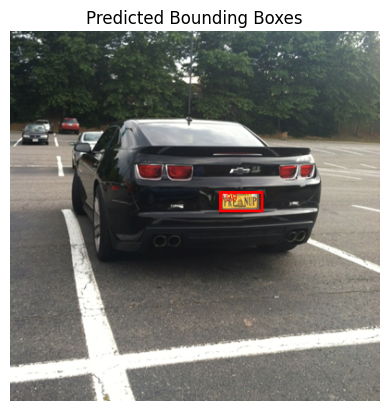

In [5]:
## Model testing
## inference

MODEL_PATH = "/content/frcnn_best.pth"
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONF_THRESH = 0.5


def load_model(model_path, num_classes=NUM_CLASSES):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(DEVICE)
    return image, image_tensor


def run_inference(image_path, model, conf_threshold=CONF_THRESH):
    image_pil, image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    boxes = predictions['boxes']
    scores = predictions['scores']


    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.load_default()

    for box, score in zip(boxes, scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = box.tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1), f"{score:.2f}", fill="red", font=font)

    return image_pil

## Test image 1
if __name__ == "__main__":
    model = load_model(MODEL_PATH)
    test_image_path = "/content/Cars2.png"
    result_image = run_inference(test_image_path, model)
    plt.imshow(result_image)
    plt.axis("off")
    plt.title("Predicted Bounding Boxes")
    plt.show()


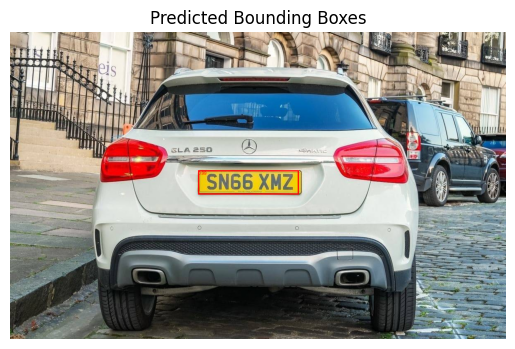

In [8]:
    ## Test with image 2
    model = load_model(MODEL_PATH)
    test_image_path = "/content/car.jpg"
    result_image = run_inference(test_image_path, model)
    plt.imshow(result_image)
    plt.axis("off")
    plt.title("Predicted Bounding Boxes")
    plt.show()
